In [1]:
import Pkg; Pkg.activate("C:/Users/s151781/AppData/Local/Julia-1.3.1/GN/Project.toml")
using Revise
using Distributions
using PyPlot
using FFTW
using Compat
using WAV
using DSP
using Base64
using ForneyLab
using LinearAlgebra
using ProgressMeter

include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/workflow.jl")
include("../functions/auxiliary/fourier.jl")
include("../functions/auxiliary/visualization.jl")
include("../functions/auxiliary/buffer.jl")
include("../functions/preprocessing.jl")

Activating environment at `C:\Users\s151781\AppData\Local\Julia-1.3.1\GN\Project.toml`


fft_expand (generic function with 1 method)

In [2]:
mutable struct AutoregressiveFilterbank <: ForneyLab.SoftFactor
    id::Symbol
    interfaces::Vector{Interface}
    i::Dict{Symbol,Interface}

    function AutoregressiveFilterbank(y, x, θ, w; id=ForneyLab.generateId(AutoregressiveFilterbank))
        
        # ensure that the input arguments are random variables
        @ensureVariables(y, x, θ, w) 
        
        # create new object
        self = new(id, Array{Interface}(undef, 4), Dict{Symbol,Interface}())
        
        # add the node to the current factor graph
        ForneyLab.addNode!(currentGraph(), self)
        
        # add argument variables to interfaces of node
        self.i[:y] = self.interfaces[1] = ForneyLab.associate!(Interface(self), y)
        self.i[:x] = self.interfaces[2] = ForneyLab.associate!(Interface(self), x)
        self.i[:θ] = self.interfaces[3] = ForneyLab.associate!(Interface(self), θ)
        self.i[:w] = self.interfaces[4] = ForneyLab.associate!(Interface(self), w)
        
        # return object
        return self
    end
end

In [3]:
# add shortcut for calling the filter bank
slug(::Type{AutoregressiveFilterbank}) = "ARFB"

slug (generic function with 1 method)

In [4]:
function ruleVariationalARFBOutNPPP(marg_y::Nothing, 
                                    marg_x::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_θ::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_w::ProbabilityDistribution{ForneyLab.MatrixVariate})

    # calculate required means
    mθ = ForneyLab.unsafeMean(marg_θ)
    mx = ForneyLab.unsafeMean(marg_x)
    mw = ForneyLab.unsafeMean(marg_w)
                        
    # calculate new parameters
    my = mθ .* mx
    wy = mw

    # create variational message
    return Message(ForneyLab.Multivariate, GaussianWeightedMeanPrecision, xi=wy*my, w=wy)

end

ruleVariationalARFBOutNPPP (generic function with 1 method)

In [5]:
function ruleVariationalARFBIn1PNPP(marg_y::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_x::Nothing, 
                                    marg_θ::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_w::ProbabilityDistribution{ForneyLab.MatrixVariate})
    
    # caluclate required means
    my = ForneyLab.unsafeMean(marg_y)
    mθ = ForneyLab.unsafeMean(marg_θ)
    mw = ForneyLab.unsafeMean(marg_w)

    # calculate required variances
    vθ = ForneyLab.unsafeCov(marg_θ)

    # calculate new parameters
    wx = (vθ' + mθ*mθ') .* mw
    mx = inv(wx) * Diagonal(mθ) * mw * my

    # create variational message
    return Message(ForneyLab.Multivariate, GaussianWeightedMeanPrecision, xi=wx*mx, w=wx)

end

ruleVariationalARFBIn1PNPP (generic function with 1 method)

In [6]:
function ruleVariationalARFBIn2PPNP(marg_y::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_x::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_θ::Nothing, 
                                    marg_w::ProbabilityDistribution{ForneyLab.MatrixVariate})

    # calculate required means
    my = ForneyLab.unsafeMean(marg_y)
    mx = ForneyLab.unsafeMean(marg_x)
    mw = ForneyLab.unsafeMean(marg_w)

    # calculate required variances
    vx = ForneyLab.unsafeCov(marg_x)

    # calculate new parameters
    wθ = (vx' + mx*mx') .* mw
    mθ = inv(wθ) * Diagonal(mx) * mw * my

    # create variational message
    Message(ForneyLab.Multivariate, GaussianWeightedMeanPrecision, xi=wθ*mθ, w=wθ)

end

ruleVariationalARFBIn2PPNP (generic function with 1 method)

In [7]:
function ruleVariationalARFBIn3PPPN(marg_y::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_x::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_θ::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_w::Nothing)

    # calculate required means
    my = ForneyLab.unsafeMean(marg_y)
    mx = ForneyLab.unsafeMean(marg_x)
    mθ = ForneyLab.unsafeMean(marg_θ)

    # calculate required variances
    vy = ForneyLab.unsafeCov(marg_y)
    vx = ForneyLab.unsafeCov(marg_x)
    vθ = ForneyLab.unsafeCov(marg_θ)

    # calculate new parameters
    v = vy + my*my' - (mθ .* mx)*my' - my*(mx .* mθ)' + Diagonal(mθ)*vx*Diagonal(mθ) + Diagonal(mx)*vθ*Diagonal(mx)  + (mθ .* mx)*(mθ .* mx)' + vθ.*vx
    nu = size(v,1) + 2 

    # create variational message
    Message(ForneyLab.MatrixVariate, ForneyLab.Wishart, v=inv(v), nu=nu)

end

ruleVariationalARFBIn3PPPN (generic function with 1 method)

In [8]:
@naiveVariationalRule(:node_type     => AutoregressiveFilterbank,
                      :outbound_type => Message{GaussianWeightedMeanPrecision},
                      :inbound_types => (Nothing, ProbabilityDistribution, ProbabilityDistribution, ProbabilityDistribution),
                      :name          => VariationalARFBOutNPPP)

@naiveVariationalRule(:node_type     => AutoregressiveFilterbank,
                      :outbound_type => Message{GaussianWeightedMeanPrecision},
                      :inbound_types => (ProbabilityDistribution, Nothing, ProbabilityDistribution, ProbabilityDistribution),
                      :name          => VariationalARFBIn1PNPP)

@naiveVariationalRule(:node_type     => AutoregressiveFilterbank,
                      :outbound_type => Message{GaussianWeightedMeanPrecision},
                      :inbound_types => (ProbabilityDistribution, ProbabilityDistribution, Nothing, ProbabilityDistribution),
                      :name          => VariationalARFBIn2PPNP)

@naiveVariationalRule(:node_type     => AutoregressiveFilterbank,
                      :outbound_type => Message{ForneyLab.Wishart},
                      :inbound_types => (ProbabilityDistribution, ProbabilityDistribution, ProbabilityDistribution, Nothing),
                      :name          => VariationalARFBIn3PPPN)


In [9]:
function generateARFB(nr_γ, bufsize)
    
    model = quote
        
        fg = FactorGraph()
        
        @RV [id=:smin] smin ~ GaussianMeanVariance(placeholder(:μ_smin, dims=(2*$nr_γ,)), placeholder(:Σ_smin, dims=(2*$nr_γ,2*$nr_γ)))
        @RV [id=:θ] θ ~ GaussianMeanVariance(placeholder(:μ_θ, dims=(2*$nr_γ,)), placeholder(:Σ_θ, dims=(2*$nr_γ,2*$nr_γ)))
        @RV [id=:w] w ~ ForneyLab.Wishart(placeholder(:v_w, dims=(2*$nr_γ,2*$nr_γ)), placeholder(:nu_w))
        @RV [id=:s] s ~ AutoregressiveFilterbank(smin, θ, w)
        @RV [id=:x] x = placeholder(:c, dims=($bufsize,2*$nr_γ)) * s
        @RV [id=:y] y ~ GaussianMeanVariance(x, placeholder(:Σ_x, dims=($bufsize,$bufsize)))
        placeholder(y, :y, dims=($bufsize,))
        
        q = PosteriorFactorization(smin, s, θ, w, ids=[:smin, :s, :θ, :w])

    end
    
end

generateARFB (generic function with 1 method)

In [10]:
# load speech data
xi, fs = wavread("../data/sin1000.wav", format="native")
fs = Int(fs)
xi = convert(Array{Float64,1}, xi[1*fs:4*fs])

# pre-process signals
yi = preprocess(xi, fs, fs_desired=2500) 

N = length(yi)
t = collect(1:N)/2500
fs = 2500

audioplayers(yi, fs=fs);

<source src="data:audio/wav;base64,UklGRnB1AABXQVZFZm10ICgAAAD+/wEAxAkAABAnAAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YTR1AACyaow+FIkXP0VNbr8T8lw/W0jivowCJr7fwjY/s/9/v9bQaD/uf/O+svgLvsK6MT/dEXy/AL5lP3u37r4cWRO+5yAzP3wcfb/OfmY/9NTvvt/bEb6D6zI/iAd9v4F+Zj/f1O++/doRvmfrMj9jB32/r35mP/PU777s2RG+Z+syP1IHfb/VfmY/D9TvvnDaEb4a6zI/OQd9v45+Zj8k1O++Y9sRvgvrMj90B32/iX5mP/TU777f2xG+g+syP4gHfb+BfmY/39Tvvv3aEb5n6zI/Ywd9v69+Zj/z1O++7NkRvmfrMj9SB32/1X5mPw/U775w2hG+GusyPzkHfb+OfmY/JNTvvmPbEb4L6zI/dAd9v4l+Zj/01O++39sRvoPrMj+IB32/gX5mP9/U77792hG+Z+syP2MHfb+vfmY/89TvvuzZEb5n6zI/Ugd9v9V+Zj8P1O++cNoRvhrrMj85B32/jn5mPyTU775j2xG+C+syP3QHfb+JfmY/9NTvvt/bEb6D6zI/iAd9v4F+Zj/f1O++/doRvmfrMj9jB32/r35mP/PU777s2RG+Z+syP1IHfb/VfmY/D9TvvnDaEb4a6zI/OQd9v45+Zj8k1O++Y9sRvgvrMj90B32/iX5mP/TU777f2xG+g+syP4gHfb+BfmY/39Tvvv3aEb5n6zI/Ywd9v69+Zj/z1O++7NkRvmfrMj9SB32/1X5mPw/U775w2hG+GusyPzkHfb+OfmY/JNTvvmPbEb4L6zI/dAd9v4l+Zj/01O++39sRvoPrMj+IB32/gX5mP9/U77792hG+Z+syP2MHfb+vfmY/89TvvuzZEb5n6zI/Ugd9v9V+Zj8P1O++cNoRvhrrMj85B32/jn5mPyTU775j2xG+C+syP3QHfb+JfmY/9NTvvt/bEb6D6zI/iAd9v4F+Zj/f1O++/doRvmfrMj9jB32/r35mP/PU777s2RG+Z+syP1IHfb/VfmY/D9TvvnDaEb4a6zI/OQd9v45+Zj8k1O++Y9sRvgvrMj90B32/iX5mP/TU777f2xG+g+syP4gHfb+BfmY/39Tvvv3aEb5n6zI/Ywd9v69+Zj/z1O++7NkRvmfrMj9SB32/1X5mPw/U775w2hG+GusyPzkHfb+OfmY/JNTvvmPbEb4L6zI/dAd9v4l+Zj/01O++39sRvoPrMj+IB32/gX5mP9/U77792hG+Z+syP2MHfb+vfmY/89TvvuzZEb5n6zI/Ugd9v9V+Zj8P1O++cNoRvhrrMj85B32/jn5mPyTU775j2xG+C+syP3QHfb+JfmY/9NTvvt/bEb6D6zI/iAd9v4F+Zj/f1O++/doRvmfrMj9jB32/r35mP/PU777s2RG+Z+syP1IHfb/VfmY/D9TvvnDaEb4a6zI/OQd9v45+Zj8k1O++Y9sRvgvrMj90B32/iX5mP/TU777f2xG+g+syP4gHfb+BfmY/39Tvvv3aEb5n6zI/Ywd9v69+Zj/z1O++7NkRvmfrMj9SB32/1X5mPw/U775w2hG+GusyPzkHfb+OfmY/JNTvvmPbEb4L6zI/dAd9v4l+Zj/01O++39sRvoPrMj+IB32/gX5mP9/U77792hG+Z+syP2MHfb+vfmY/89TvvuzZEb5n6zI/Ugd9v9V+Zj8P1O++cNoRvhrrMj85B32/jn5mPyTU775j2xG+C+syP3QHfb+JfmY/9NTvvt/bEb6D6zI/iAd9v4F+Zj/f1O++/doRvmfrMj9jB32/r35mP/PU777s2RG+Z+syP1IHfb/VfmY/D9TvvnDaEb4a6zI/OQd9v45+Zj8k1O++Y9sRvgvrMj90B32/iX5mP/TU777f2xG+g+syP4gHfb+BfmY/39Tvvv3aEb5n6zI/Ywd9v69+Zj/z1O++7NkRvmfrMj9SB32/1X5mPw/U775w2hG+GusyPzkHfb+OfmY/JNTvvmPbEb4L6zI/dAd9v4l+Zj/01O++39sRvoPrMj+IB32/gX5mP9/U77792hG+Z+syP2MHfb+vfmY/89TvvuzZEb5n6zI/Ugd9v9V+Zj8P1O++cNoRvhrrMj85B32/jn5mPyTU775j2xG+C+syP3QHfb+JfmY/9NTvvt/bEb6D6zI/iAd9v4F+Zj/f1O++/doRvmfrMj9jB32/r35mP/PU777s2RG+Z+syP1IHfb/VfmY/D9TvvnDaEb4a6zI/OQd9v45+Zj8k1O++Y9sRvgvrMj90B32/iX5mP/TU777f2xG+g+syP4gHfb+BfmY/39Tvvv3aEb5n6zI/Ywd9v69+Zj/z1O++7NkRvmfrMj9SB32/1X5mPw/U775w2hG+GusyPzkHfb+OfmY/JNTvvmPbEb4L6zI/dAd9v4l+Zj/01O++39sRvoPrMj+IB32/gX5mP9/U77792hG+Z+syP2MHfb+vfmY/89TvvuzZEb5n6zI/Ugd9v9V+Zj8P1O++cNoRvhrrMj85B32/jn5mPyTU775j2xG+C+syP3QHfb+JfmY/9NTvvt/bEb6D6zI/iAd9v4F+Zj/f1O++/doRvmfrMj9jB32/r35mP/PU777s2RG+Z+syP1IHfb/VfmY/D9TvvnDaEb4a6zI/OQd9v45+Zj8k1O++Y9sRvgvrMj90B32/iX5mP/TU777f2xG+g+syP4gHfb+BfmY/39Tvvv3aEb5n6zI/Ywd9v69+Zj/z1O++7NkRvmfrMj9SB32/1X5mPw/U775w2hG+GusyPzkHfb+OfmY/JNTvvmPbEb4L6zI/dAd9v4l+Zj/01O++39sRvoPrMj+IB32/gX5mP9/U77792hG+Z+syP2MHfb+vfmY/89TvvuzZEb5n6zI/Ugd9v9V+Zj8P1O++cNoRvhrrMj85B32/jn5mPyTU775j2xG+C+syP3QHfb+JfmY/9NTvvt/bEb6D6zI/iAd9v4F+Zj/f1O++/doRvmfrMj9jB32/r35mP/PU777s2RG+Z+syP1IHfb/VfmY/D9TvvnDaEb4a6zI/OQd9v45+Zj8k1O++Y9sRvgvrMj90B32/iX5mP/TU777f2xG+g+syP4gHfb+BfmY/39Tvvv3aEb5n6zI/Ywd9v69+Zj/z1O++7NkRvmfrMj9SB32/1X5mPw/U775w2hG+GusyPzkHfb+OfmY/JNTvvmPbEb4L6zI/dAd9v4l+Zj/01O++39sRvoPrMj+IB32/gX5mP9/U77792hG+Z+syP2MHfb+vfmY/89TvvuzZEb5n6zI/Ugd9v9V+Zj8P1O++cNoRvhrrMj85B32/jn5mPyTU775j2xG+C+syP3QHfb+JfmY/9NTvvt/bEb6D6zI/iAd9v4F+Zj/f1O++/doRvmfrMj9jB32/r35mP/PU777s2RG+Z+syP1IHfb/VfmY/D9TvvnDaEb4a6zI/OQd9v45+Zj8k1O++Y9sRvgvrMj90B32/iX5mP/TU777f2xG+g+syP4gHfb+BfmY/39Tvvv3aEb5n6zI/Ywd9v69+Zj/z1O++7NkRvmfrMj9SB32/1X5mPw/U775w2hG+GusyPzkHfb+OfmY/JNTvvmPbEb4L6zI/dAd9v4l+Zj/01O++39sRvoPrMj+IB32/gX5mP9/U77792hG+Z+syP2MHfb+vfmY/89TvvuzZEb5n6zI/Ugd9v9V+Zj8P1O++cNoRvhrrMj85B32/jn5mPyTU775j2xG+C+syP3QHfb+JfmY/9NTvvt/bEb6D6zI/iAd9v4F+Zj/f1O++/doRvmfrMj9jB32/r35mP/PU777s2RG+Z+syP1IHfb/VfmY/D9TvvnDaEb4a6zI/OQd9v45+Zj8k1O++Y9sRvgvrMj90B32/iX5mP/TU777f2xG+g+syP4gHfb+BfmY/39Tvvv3aEb5n6

In [11]:
f = collect(fs/20:fs/20:fs/2)
bufsize = 2*length(f)

# create fg
eval(generateARFB(length(f), bufsize))
ForneyLab.draw(fg)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 6277775798257769943 -->
 6277775798257769943 
 
 placeholder_y 
 
<!-- 17683356101434439467 -->
 17683356101434439467 
 
 𝒩 
 gaussianmeanvariance_3 
 
<!-- 6277775798257769943--17683356101434439467 -->
 6277775798257769943--17683356101434439467 
 
 y 
 1 out 
 1 out 
 
<!-- 1457341325925725637 -->
 1457341325925725637 
 
 AutoregressiveFilterbank 
 autoregressivefilterbank_1 
 
<!-- 13200293368470378790 -->
 13200293368470378790 
 
 𝒩 
 gaussianmeanvariance_1 
 
<!-- 1457341325925725637--13200293368470378790 -->
 1457341325925725637--13200293368470378790 
 
 smin 
 1 out 
 2 x 
 
<!-- 555889473987903894 -->
 555889473987903894 
 
 𝒩 
 gaussianmeanvariance_2 
 
<!-- 1457341325925725637--555889473987903894 -->
 1457341325925725637--555889473987903894 
 
 θ 
 1 out 
 3 θ 
 
<!-- 14792214041681048429 -->
 14792214041681048429 
 
 W 
 wishart_1 
 
<!-- 1457341325925725637--14792214041681048429 -->
 1457341325925725637--14792214041681048429 
 
 w 
 1 out 
 4 w 
 
<!-- 17274032581519430046 -->
 17274032581519430046 
 
 placeholder_nu_w 
 
<!-- 5462706518230481717 -->
 5462706518230481717 
 
 placeholder_Σ_smin 
 
<!-- 13200293368470378790--5462706518230481717 -->
 13200293368470378790--5462706518230481717 
 
 Σ_smin 
 1 out 
 3 v 
 
<!-- 18424801148403492558 -->
 18424801148403492558 
 
 placeholder_μ_smin 
 
<!-- 13200293368470378790--18424801148403492558 -->
 13200293368470378790--18424801148403492558 
 
 μ_smin 
 1 out 
 2 m 
 
<!-- 5087729091719528630 -->
 5087729091719528630 
 
 placeholder_v_w 
 
<!-- 11146713042675743419 -->
 11146713042675743419 
 
 placeholder_Σ_x 
 
<!-- 17683356101434439467--11146713042675743419 -->
 17683356101434439467--11146713042675743419 
 
 Σ_x 
 1 out 
 3 v 
 
<!-- 11212846210412949635 -->
 11212846210412949635 
 
 × 
 multiplication_1 
 
<!-- 17683356101434439467--11212846210412949635 -->
 17683356101434439467--11212846210412949635 
 
 x 
 1 out 
 2 m 
 
<!-- 5654361840274607141 -->
 5654361840274607141 
 
 placeholder_Σ_θ 
 
<!-- 12959987412571586828 -->
 12959987412571586828 
 
 placeholder_μ_θ 
 
<!-- 11212846210412949635--1457341325925725637 -->
 11212846210412949635--1457341325925725637 
 
 s 
 1 y 
 2 in1 
 
<!-- 17179599805548478670 -->
 17179599805548478670 
 
 placeholder_c 
 
<!-- 11212846210412949635--17179599805548478670 -->
 11212846210412949635--17179599805548478670 
 
 c 
 1 out 
 3 a 
 
<!-- 555889473987903894--5654361840274607141 -->
 555889473987903894--5654361840274607141 
 
 Σ_θ 
 1 out 
 3 v 
 
<!-- 555889473987903894--12959987412571586828 -->
 555889473987903894--12959987412571586828 
 
 μ_θ 
 1 out 
 2 m 
 
<!-- 14792214041681048429--17274032581519430046 -->
 14792214041681048429--17274032581519430046 
 
 nu_w 
 1 out 
 3 nu 
 
<!-- 14792214041681048429--5087729091719528630 -->
 14792214041681048429--5087729091719528630 
 
 v_w 
 1 out 
 2 v

In [12]:
# generate algorithm
algo = variationalAlgorithm(q)
source_code = compatibility_fix(algorithmSourceCode(algo))
eval(Meta.parse(source_code))
println(source_code)

begin

function stepw!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 2))

messages[1] = ruleVBWishartOut(nothing, ProbabilityDistribution(MatrixVariate, PointMass, m=data[:v_w]), ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:nu_w]))
messages[2] = ruleVariationalARFBIn3PPPN(marginals[:s], marginals[:smin], marginals[:θ], nothing)

marginals[:w] = messages[1].dist * messages[2].dist

return marginals

end

function steps!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 4))

messages[1] = ruleVariationalARFBOutNPPP(nothing, marginals[:smin], marginals[:θ], marginals[:w])
messages[2] = ruleSPMultiplicationOutNGP(nothing, messages[1], Message(MatrixVariate, PointMass, m=data[:c]))
messages[3] = ruleVBGaussianMeanVarianceM(ProbabilityDistribution(ForneyLab.Multivariate, PointMass, m=data[:y]), nothing, ProbabilityDistribution(MatrixVariate, PointMass, m=data[:Σ_x]))
messages[4] = ruleSPMultiplication

In [13]:
yifft = FFTovertime(yi, bufsize, bufsize-1, rectangularwindow; pad=0)
yifftr = real.(yifft)
ρ = [abs.(cor(yifftr[2:end,k], yifftr[1:end-1,k])) for k = 2:length(f)+1]
ρw = [1/abs.(cov(yifftr[2:end,k], yifftr[1:end-1,k])) for k=2:length(f)+1]
ρ = repeat(ρ, inner=2)
ρw = repeat(ρw, inner=2)

20-element Array{Float64,1}:
 247893.0037242981        
 247893.0037242981        
 243302.74642295882       
 243302.74642295882       
 235102.50385852333       
 235102.50385852333       
 222515.79961004137       
 222515.79961004137       
 204351.34276153432       
 204351.34276153432       
 179159.48526162803       
 179159.48526162803       
 145509.79426139756       
 145509.79426139756       
      0.024563785998667962
      0.024563785998667962
  53107.73057516595       
  53107.73057516595       
  19027.778086448787      
  19027.778086448787      

In [14]:
μ_θ_mem = Array{Float64,2}(undef, N, 2*length(f))
Σ_θ_mem = Array{Float64,2}(undef, N, 2*length(f))
μ_s_mem = Array{Float64,2}(undef, N, 2*length(f))
μ_x_mem = Array{Float64,1}(undef, N)
Σ_x_mem = Array{Float64,1}(undef, N)
v_w_mem = Array{Float64,2}(undef, N, 2*length(f))
det_v_w_mem = Array{Float64,1}(undef, N)

# priors
μ_smin = zeros(2*length(f))
Σ_smin = 0.01*Ic(2*length(f))
μ_θ = ρ #ones(2*length(f))
Σ_θ = 1e-1*Ic(2*length(f))
v_w = 1000*diagm(ρw)/(2*length(f) + 2)
nu_w = 2*length(f) + 2
Σ_x = 1e-4*Ic(bufsize)

p = Progress(N-bufsize)
    marginals = Dict()

for n = bufsize:N
    
    next!(p)
    
    # fill marginals dictionary
    marginals[:smin] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=μ_smin, v=Σ_smin)
    marginals[:θ] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=μ_θ, v=Σ_θ)
    marginals[:w] = ProbabilityDistribution(ForneyLab.MatrixVariate, ForneyLab.Wishart, v=v_w, nu=nu_w)
    
    # fill data dictionary
    data = Dict()
    data[:μ_smin] = μ_smin
    data[:Σ_smin] = Σ_smin
    data[:μ_θ] = μ_θ
    data[:Σ_θ] = Σ_θ
    data[:v_w] = v_w
    data[:nu_w] = nu_w
    data[:c] = reshape( [cos.(2*pi*f*t[n-bufsize+1:n]') sin.(2*pi*f*t[n-bufsize+1:n]')]', bufsize, 2*length(f))
    data[:Σ_x] = Σ_x*Ic(bufsize)
    data[:y] = yi[n-bufsize+1:n]   
    
    # make prediction
    messages = Array{Message}(undef, 4)
    Base.invokelatest(steps!, data, marginals, messages)
    μ_x_mem[n] = ForneyLab.unsafeMean(messages[2].dist)[end]
    Σ_x_mem[n] = ForneyLab.unsafeCov(messages[2].dist)[end,end]
    
    # perform updates
    for _ in 1:5
        Base.invokelatest(steps!, data, marginals)
        Base.invokelatest(stepθ!, data, marginals)
        Base.invokelatest(stepw!, data, marginals)
        Base.invokelatest(stepsmin!, data, marginals)
    end
    
    # update parameters
    μ_smin = ForneyLab.unsafeMean(marginals[:s])
    Σ_smin = ForneyLab.unsafeCov(marginals[:s])
    μ_θ = ForneyLab.unsafeMean(marginals[:θ])
    Σ_θ = ForneyLab.unsafeCov(marginals[:θ])
    v_w = marginals[:w].params[:v]
    nu_w = marginals[:w].params[:nu]

    # save parameters
    μ_θ_mem[n,:] = μ_θ
    Σ_θ_mem[n,:] = diag(Σ_θ)
    μ_s_mem[n,:] = μ_smin
    v_w_mem[n,:] = diag(v_w)
    det_v_w_mem[n] = det(v_w)
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:02:15mmmmmmmmm9mmm


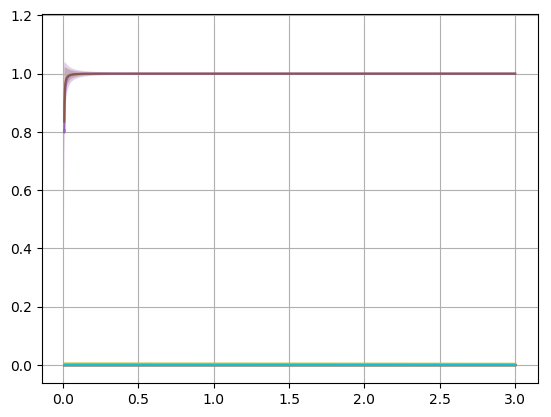

In [15]:
for k = 1:size(μ_θ_mem,2)
    plt.plot(t[bufsize:end], μ_θ_mem[bufsize:end,k])
    plt.fill_between(t[bufsize:end], μ_θ_mem[bufsize:end,k].+sqrt.(Σ_θ_mem[bufsize:end,k]), μ_θ_mem[bufsize:end,k].-sqrt.(Σ_θ_mem[bufsize:end,k]), alpha=0.3)
end
plt.grid()

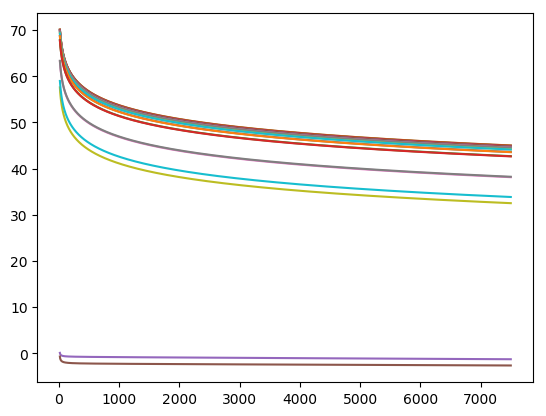

In [16]:
plt.plot(10*log10.(v_w_mem))
;

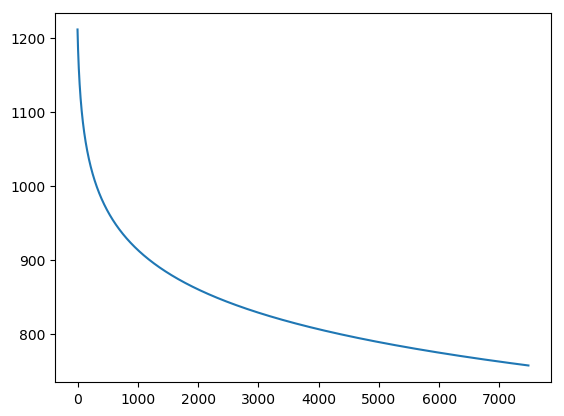

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000002203940>

In [27]:
plt.plot(10*log10.(det_v_w_mem[bufsize:end]))

<source src="data:audio/wav;base64,UklGRiR1AABXQVZFZm10ICgAAAD+/wEAECcAAECcAAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0Yeh0AAD01O++39sRvoPrMj+IB32/gX5mP9/U77792hG+Z+syP2MHfb+vfmY/89TvvuzZEb5n6zI/Ugd9v9V+Zj8P1O++cNoRvhrrMj85B32/jn5mPyTU775j2xG+C+syP3QHfb+JfmY/9NTvvt/bEb6D6zI/iAd9v4F+Zj/f1O++/doRvmfrMj9jB32/r35mP/PU777s2RG+Z+syP1IHfb/VfmY/D9TvvnDaEb4a6zI/OQd9v45+Zj8k1O++Y9sRvgvrMj90B32/iX5mP/TU777f2xG+g+syP4gHfb+BfmY/39Tvvv3aEb5n6zI/Ywd9v69+Zj/z1O++7NkRvmfrMj9SB32/1X5mPw/U775w2hG+GusyPzkHfb+OfmY/JNTvvmPbEb4L6zI/dAd9v4l+Zj/01O++39sRvoPrMj+IB32/gX5mP9/U77792hG+Z+syP2MHfb+vfmY/89TvvuzZEb5n6zI/Ugd9v9V+Zj8P1O++cNoRvhrrMj85B32/jn5mPyTU775j2xG+C+syP3QHfb+JfmY/9NTvvt/bEb6D6zI/iAd9v4F+Zj/f1O++/doRvmfrMj9jB32/r35mP/PU777s2RG+Z+syP1IHfb/VfmY/D9TvvnDaEb4a6zI/OQd9v45+Zj8k1O++Y9sRvgvrMj90B32/iX5mP/TU777f2xG+g+syP4gHfb+BfmY/39Tvvv3aEb5n6zI/Ywd9v69+Zj/z1O++7NkRvmfrMj9SB32/1X5mPw/U775w2hG+GusyPzkHfb+OfmY/JNTvvmPbEb4L6zI/dAd9v4l+Zj/01O++39sRvoPrMj+IB32/gX5mP9/U77792hG+Z+syP2MHfb+vfmY/89TvvuzZEb5n6zI/Ugd9v9V+Zj8P1O++cNoRvhrrMj85B32/jn5mPyTU775j2xG+C+syP3QHfb+JfmY/9NTvvt/bEb6D6zI/iAd9v4F+Zj/f1O++/doRvmfrMj9jB32/r35mP/PU777s2RG+Z+syP1IHfb/VfmY/D9TvvnDaEb4a6zI/OQd9v45+Zj8k1O++Y9sRvgvrMj90B32/iX5mP/TU777f2xG+g+syP4gHfb+BfmY/39Tvvv3aEb5n6zI/Ywd9v69+Zj/z1O++7NkRvmfrMj9SB32/1X5mPw/U775w2hG+GusyPzkHfb+OfmY/JNTvvmPbEb4L6zI/dAd9v4l+Zj/01O++39sRvoPrMj+IB32/gX5mP9/U77792hG+Z+syP2MHfb+vfmY/89TvvuzZEb5n6zI/Ugd9v9V+Zj8P1O++cNoRvhrrMj85B32/jn5mPyTU775j2xG+C+syP3QHfb+JfmY/9NTvvt/bEb6D6zI/iAd9v4F+Zj/f1O++/doRvmfrMj9jB32/r35mP/PU777s2RG+Z+syP1IHfb/VfmY/D9TvvnDaEb4a6zI/OQd9v45+Zj8k1O++Y9sRvgvrMj90B32/iX5mP/TU777f2xG+g+syP4gHfb+BfmY/39Tvvv3aEb5n6zI/Ywd9v69+Zj/z1O++7NkRvmfrMj9SB32/1X5mPw/U775w2hG+GusyPzkHfb+OfmY/JNTvvmPbEb4L6zI/dAd9v4l+Zj/01O++39sRvoPrMj+IB32/gX5mP9/U77792hG+Z+syP2MHfb+vfmY/89TvvuzZEb5n6zI/Ugd9v9V+Zj8P1O++cNoRvhrrMj85B32/jn5mPyTU775j2xG+C+syP3QHfb+JfmY/9NTvvt/bEb6D6zI/iAd9v4F+Zj/f1O++/doRvmfrMj9jB32/r35mP/PU777s2RG+Z+syP1IHfb/VfmY/D9TvvnDaEb4a6zI/OQd9v45+Zj8k1O++Y9sRvgvrMj90B32/iX5mP/TU777f2xG+g+syP4gHfb+BfmY/39Tvvv3aEb5n6zI/Ywd9v69+Zj/z1O++7NkRvmfrMj9SB32/1X5mPw/U775w2hG+GusyPzkHfb+OfmY/JNTvvmPbEb4L6zI/dAd9v4l+Zj/01O++39sRvoPrMj+IB32/gX5mP9/U77792hG+Z+syP2MHfb+vfmY/89TvvuzZEb5n6zI/Ugd9v9V+Zj8P1O++cNoRvhrrMj85B32/jn5mPyTU775j2xG+C+syP3QHfb+JfmY/9NTvvt/bEb6D6zI/iAd9v4F+Zj/f1O++/doRvmfrMj9jB32/r35mP/PU777s2RG+Z+syP1IHfb/VfmY/D9TvvnDaEb4a6zI/OQd9v45+Zj8k1O++Y9sRvgvrMj90B32/iX5mP/TU777f2xG+g+syP4gHfb+BfmY/39Tvvv3aEb5n6zI/Ywd9v69+Zj/z1O++7NkRvmfrMj9SB32/1X5mPw/U775w2hG+GusyPzkHfb+OfmY/JNTvvmPbEb4L6zI/dAd9v4l+Zj/01O++39sRvoPrMj+IB32/gX5mP9/U77792hG+Z+syP2MHfb+vfmY/89TvvuzZEb5n6zI/Ugd9v9V+Zj8P1O++cNoRvhrrMj85B32/jn5mPyTU775j2xG+C+syP3QHfb+JfmY/9NTvvt/bEb6D6zI/iAd9v4F+Zj/f1O++/doRvmfrMj9jB32/r35mP/PU777s2RG+Z+syP1IHfb/VfmY/D9TvvnDaEb4a6zI/OQd9v45+Zj8k1O++Y9sRvgvrMj90B32/iX5mP/TU777f2xG+g+syP4gHfb+BfmY/39Tvvv3aEb5n6zI/Ywd9v69+Zj/z1O++7NkRvmfrMj9SB32/1X5mPw/U775w2hG+GusyPzkHfb+OfmY/JNTvvmPbEb4L6zI/dAd9v4l+Zj/01O++39sRvoPrMj+IB32/gX5mP9/U77792hG+Z+syP2MHfb+vfmY/89TvvuzZEb5n6zI/Ugd9v9V+Zj8P1O++cNoRvhrrMj85B32/jn5mPyTU775j2xG+C+syP3QHfb+JfmY/9NTvvt/bEb6D6zI/iAd9v4F+Zj/f1O++/doRvmfrMj9jB32/r35mP/PU777s2RG+Z+syP1IHfb/VfmY/D9TvvnDaEb4a6zI/OQd9v45+Zj8k1O++Y9sRvgvrMj90B32/iX5mP/TU777f2xG+g+syP4gHfb+BfmY/39Tvvv3aEb5n6zI/Ywd9v69+Zj/z1O++7NkRvmfrMj9SB32/1X5mPw/U775w2hG+GusyPzkHfb+OfmY/JNTvvmPbEb4L6zI/dAd9v4l+Zj/01O++39sRvoPrMj+IB32/gX5mP9/U77792hG+Z+syP2MHfb+vfmY/89TvvuzZEb5n6zI/Ugd9v9V+Zj8P1O++cNoRvhrrMj85B32/jn5mPyTU775j2xG+C+syP3QHfb+JfmY/9NTvvt/bEb6D6zI/iAd9v4F+Zj/f1O++/doRvmfrMj9jB32/r35mP/PU777s2RG+Z+syP1IHfb/VfmY/D9TvvnDaEb4a6zI/OQd9v45+Zj8k1O++Y9sRvgvrMj90B32/iX5mP/TU777f2xG+g+syP4gHfb+BfmY/39Tvvv3aEb5n6zI/Ywd9v69+Zj/z1O++7NkRvmfrMj9SB32/1X5mPw/U775w2hG+GusyPzkHfb+OfmY/JNTvvmPbEb4L6zI/dAd9v4l+Zj/01O++39sRvoPrMj+IB32/gX5mP9/U77792hG+Z+syP2MHfb+vfmY/89TvvuzZEb5n6zI/Ugd9v9V+Zj8P1O++cNoRvhrrMj85B32/jn5mPyTU775j2xG+C+syP3QHfb+JfmY/9NTvvt/bEb6D6zI/iAd9v4F+Zj/f1O++/doRvmfrMj9jB32/r35mP/PU777s2RG+Z+syP1IHfb/VfmY/D9TvvnDaEb4a6zI/OQd9v45+Zj8k1O++Y9sRvgvrMj90B32/iX5mP/TU777f2

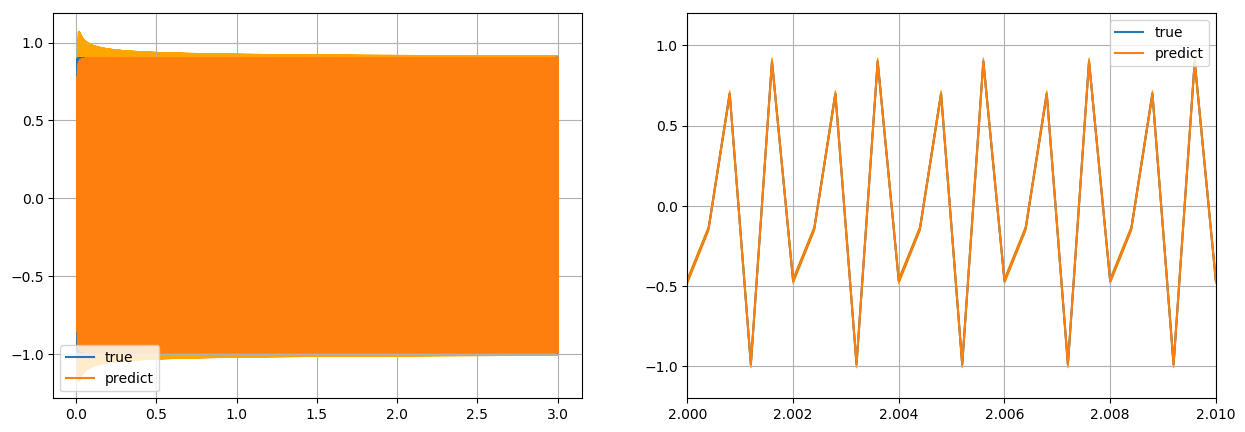

In [18]:
_, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[1].plot(t[bufsize:end], yi[bufsize:end], label="true")
ax[1].plot(t[bufsize:end], μ_x_mem[bufsize:end], label="predict")
ax[1].fill_between(t[bufsize:end], μ_x_mem[bufsize:end] .+ sqrt.(Σ_x_mem[bufsize:end]), μ_x_mem[bufsize:end] .- sqrt.(Σ_x_mem[bufsize:end]), color="orange")
ax[1].grid(), ax[1].legend()
ax[2].plot(t[bufsize:end], yi[bufsize:end], label="true")
ax[2].plot(t[bufsize:end], μ_x_mem[bufsize:end], label="predict")
ax[2].fill_between(t[bufsize:end], μ_x_mem[bufsize:end] .+ sqrt.(Σ_x_mem[bufsize:end]), μ_x_mem[bufsize:end] .- sqrt.(Σ_x_mem[bufsize:end]), color="orange")
ax[2].grid(), ax[2].legend(), ax[2].set_xlim(2,2.01), ax[2].set_ylim(-1.2,1.2)
audioplayers(yi[bufsize:end], μ_x_mem[bufsize:end], fs=fs*4)

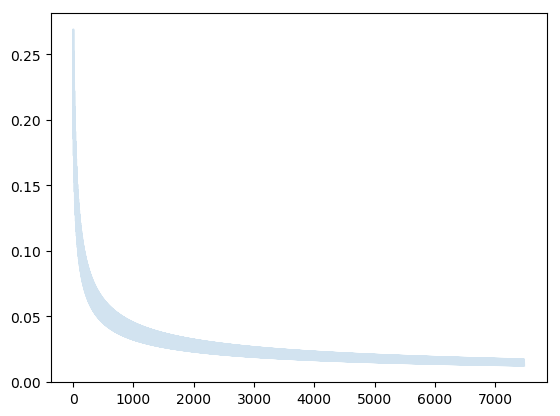

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000001E64748>

In [19]:
plt.plot(sqrt.(Σ_x_mem[bufsize:end]), alpha=0.2)

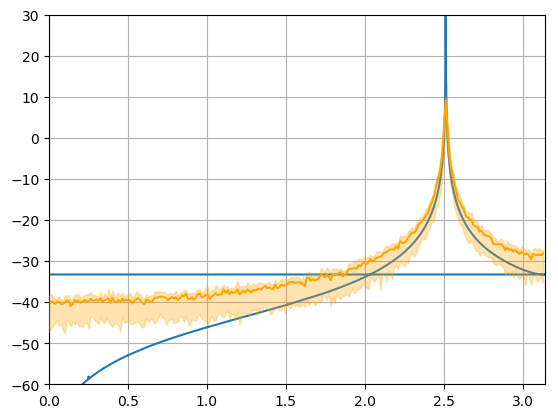

In [20]:
# generation:
Ni = 500 # (nr samples + frequency resolution)
Mi = 100 # nr of iterations

# get parameters
μ_θi, Σ_θi = ForneyLab.unsafeMean(marginals[:θ]), ForneyLab.unsafeCov(marginals[:θ])
v_wi, nu_wi = marginals[:w].params[:v], marginals[:w].params[:nu]


function generate1psd(μ_θi, Σ_θi, v_wi, nu_wi, N, fs, f)
    # create signal (option 1)
    sif = Array{Float64,2}(undef, 2*length(f), N)
    xif = Array{Float64,1}(undef, N)
    sif[:,1] = zeros(2*length(f))
    xif[1] = 0
    for n = 2:N
        θs = rand(MvNormal(μ_θi, collect(Hermitian(Σ_θi))))
        ws = rand(MvNormal(zeros(2*length(f)), collect(Hermitian(inv(rand(Distributions.Wishart(nu_wi, collect(Hermitian(v_wi)))))))))
        sif[:,n] = θs.*sif[:,n-1] + ws
        xif[n] = collect(sif[:,n]'*reshape( [cos.(2*pi*f/fs*n') sin.(2*pi*f/fs*n')]', 1, 2*length(f))')[1,1]
    end
    return xif
end

function approxpsd(M, μ_θi, Σ_θi, v_wi, nu_wi, N, fs, f)
    psd = Array{Float64,2}(undef, M, N) 
    for m = 1:M
        xif = generate1psd(μ_θi, Σ_θi, v_wi, nu_wi, N, fs, f)
        psd[m,:] = (abs.(FFTW.fft(xif)).^2)./length(xif)
    end
    return squeeze(10*log10.(mean(psd, dims=1))), squeeze(10*log10.([quantile(psd[:,k], 0.25) for k = 1:N])), squeeze(10*log10.([quantile(psd[:,k], 0.75) for k = 1:N]))
end

mean_psd, std_psd1, std_psd2 = approxpsd(Mi, μ_θi, Σ_θi, v_wi, nu_wi, Ni, fs, f)
mean_psd = mean_psd[1:Int(floor(Ni/2))]
std_psd1 = std_psd1[1:Int(floor(Ni/2))]
std_psd2 = std_psd2[1:Int(floor(Ni/2))]
plt.plot(FFTW.fftfreq(length(yi), fs)/fs*2*pi, 10*log10.((abs.(FFTW.fft(yi)).^2)./length(yi)))
plt.plot(FFTW.fftfreq(Ni, fs)[1:Int(floor(Ni/2))]/fs*2*pi, mean_psd, color="orange")
plt.fill_between(FFTW.fftfreq(Ni, fs)[1:Int(floor(Ni/2))]/fs*2*pi, std_psd1, std_psd2, color="orange", alpha=0.3, zorder=100)
plt.xlim(0,pi)
plt.ylim(-60,30)
plt.grid()
;

In [21]:
x_true = yi[bufsize:end]
x_μ_pred = μ_x_mem[bufsize:end]
x_σ_pred = sqrt.(abs.(Σ_x_mem[bufsize:end]));

In [22]:
MSE = mean(abs2.(x_true - x_μ_pred))
MAE = mean(abs.(x_true - x_μ_pred))
BME = mean([logpdf(Normal(x_μ_pred[k], x_σ_pred[k]), x_true[k]) for k = 1:length(x_true)])

MSE, MAE, BME

(5.150341629246808e-5, 0.00041531171860219513, 2.7773297625088653)

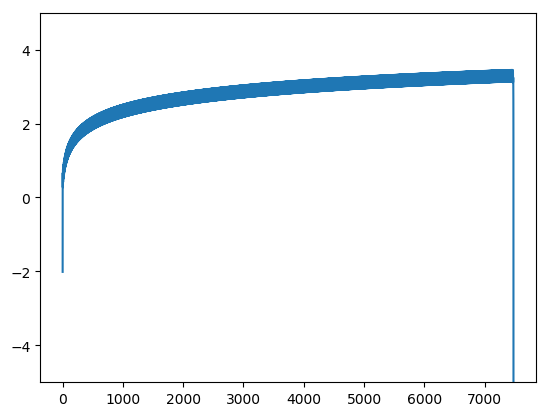

(-5, 5)

In [23]:
plt.plot([logpdf(Normal(x_μ_pred[k], x_σ_pred[k]), x_true[k]) for k = 1:length(x_true)])
plt.ylim(-5,5)